# Danish age-corrected murder rates 1980-2022

### Table of contents:
1. Introduction

2. Convictions as proxy for incidence

3. Age-corrected murder rates

In [ ]:
%pip install git+https://github.com/elben10/pydst

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pydst
import statsmodels.api as sm
%load_ext autoreload
%autoreload 2

### 1 Introduction

From time to time articles appear in Danish media discussing the observed reductions in crime rates since the mid 90's. A possible confounder rarely discussed is the concurrent changes in the age structure of Danish society. Since the vast majority of violent ('personfarlig') crime is commited by young men in their teens to their early twenties, this is potentially a serious confounder. In this short project, we examine how the age-corrected murder rate ('manddrab') has changed over time from 1980 to 2022. 

Why murder rate? Since both social and judicial definitions of violent crime have evolved over time, it is difficult to argue that increases in e.g. reported assaults or rapes directly reflect increases in objective incidence rates. Murder is in comparison a far more fixed entity, requiring a dead body and evidence of intentional homicide. 

Utilizing data from Danmarks Statistik on murder convictions and population age structure from 1980 to 2022, we compute age-specific murder rates for each year. We then find the specific age structure of the year 1980, expressed in fractions. These 1980 population age fractions are then scaled onto the age-specific murder rates in all years, producing the age-corrected murder rates that when summed for a given year reflect *what the murder rate would have been in a given year, had the population age structure in the given year been identical to the age structure of 1980*.  


### 2 Convictions as proxy for incidence

Given that we only have data on the characteristics of those convicted for murder, rather than on those who have perpetrated murder, there remains the issue of whether convictions are a sufficient proxy for incidence. Since we are interested in the development over time of the murder rate, confounders would lie in developments in the relationship over time between the conviction rate and the incidence rate, which may render the conviction rate a bad proxy for the incidence rate. As an example, police might have increased clearance rates over the period in question, which would bias results upwards (an appearance of more murder over time). For this reason we plot the evolution in the number of murders minus the number of convictions for murder over the period in question.

#### 2.1. Importing, exploring, cleaning data for murder incidence and convictions

In [2]:
Dst = pydst.Dst(lang='da') #Using API from Danmarks Statistik

#Extracting data on murder convictions
variables = {'KØN':['M','K'], 'ALDER':['*'], 'AFGØRELSE':['1','2','511','516','517','518'],'Tid':['*'], 'OVERTRÆD':['1230']} 
råstraf = Dst.get_data(table_id = 'STRAF40', variables=variables)
råstraf.sort_values(by=['KØN', 'ALDER', 'TID'], inplace=True)

straf_sum = råstraf.groupby(['ALDER', 'TID']).sum(numeric_only=1) #Summing all the pertinent (guilty) judicial rulings into one number for each year and age category
straf = pd.pivot_table(straf_sum, index = ['ALDER'], columns = ['TID']) #Pivoting table into a more useful format
straf2 = straf.convert_dtypes() #Converting object types to integers to save the world
straf3 = straf2.rename(columns={'INDHOLD':' Table 1 - Danish murder convictions by age category 1980-2022'})
display(straf3)

Table 1 - Danish murder convictions by age category 1980-2022  \
TID                                                                        1980   
ALDER                                                                             
15 år                                                          <NA>               
16 år                                                          <NA>               
17 år                                                          <NA>               
18 år                                                             1               
19 år                                                          <NA>               
20 år                                                          <NA>               
21 år                                                             2               
22 år                                                             1               
23 år                                                          <NA>               
24 år                                                             1               
25-29 år                                                          6               
30-39 år                                                          9               
40-49 år                                                          2               
50-59 år                                                          3               
60-69 år                                                          1               
70-79 år                                                          1               
80 år og derover                                               <NA>               
Alder i alt                                                      27               

                                                                        ...  \
TID               1981  1982  1983  1984  1985  1986  1987  1988  1989  ...   
ALDER                                                                   ...   
15 år             <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  ...   
16 år                1  <NA>     1     1  <NA>     1  <NA>  <NA>  <NA>  ...   
17 år                1  <NA>  <NA>  <NA>  <NA>  <NA>     1  <NA>  <NA>  ...   
18 år             <NA>  <NA>     1     1  <NA>     1  <NA>     1  <NA>  ...   
19 år                2     2     1     1  <NA>     2     2  <NA>     1  ...   
20 år                2     1     2  <NA>     2     1  <NA>     1  <NA>  ...   
21 år                2     2     1  <NA>  <NA>     2     1  <NA>  <NA>  ...   
22 år                1  <NA>     1  <NA>  <NA>     3  <NA>     3     1  ...   
23 år                4  <NA>     1  <NA>     1  <NA>     1     1     4  ...   
24 år             <NA>     2     2     2     2  <NA>     1     1     2  ...   
25-29 år             4     6    10     6     9     4    10     6     4  ...   
30-39 år             7    12     9    10     8    13     8    11    12  ...   
40-49 år             4     5     6     9     4    11     3     5     5  ...   
50-59 år             2     3     4     2     4     2     4     1     2  ...   
60-69 år             2  <NA>     1     2  <NA>     2     3  <NA>     1  ...   
70-79 år          <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  ...   
80 år og derover  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  ...   
Alder i alt         32    33    40    34    30    42    34    30    32  ...   

                                                                              
TID               2013  2014  2015  2016  2017  2018  2019  2020  2021  2022  
ALDER                                                                         
15 år             <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  
16 år             <NA>  <NA>     2     1  <NA>  <NA>  <NA>     1     1  <NA>  
17 år                2     1  <NA>     1  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  
18 år             <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>     1     1     1  
19 år                1  <NA>  <NA>     1  <NA>     1     1   

In [3]:
#Extracting data on murder incidence
variables2 = {'ANMSIGT':['ANM'],'OVERTRÆD':['1230'], 'Tid':['*']}
anmeldte = Dst.get_data(table_id = 'STRAF20', variables=variables2)
del anmeldte['OVERTRÆD']
del anmeldte['ANMSIGT']
anmeldte = anmeldte.rename(columns={"INDHOLD":"Antal"})
anmeldte = pd.pivot_table(anmeldte, columns='TID')
anmeldte.style.set_caption('Table 2 - Murder incidence by year, 1995-2022')


TID,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
Antal,60,69,88,49,52,58,52,48,66,44,53,29,45,53,56,49,49,43,41,59,46,49,54,52,48,49,39,55


#### 2.2 Visualizing the proxy relationship

         TID 
INDHOLD  1995    20
         1996    22
         1997    47
         1998     8
         1999    19
         2000    26
         2001    16
         2002    17
         2003    35
         2004    16
         2005    21
         2006     2
         2007    27
         2008    31
         2009    21
         2010    -5
         2011    23
         2012     9
         2013    17
         2014    37
         2015    14
         2016    30
         2017    23
         2018    25
         2019    29
         2020    10
         2021    12
         2022    31
dtype: int32

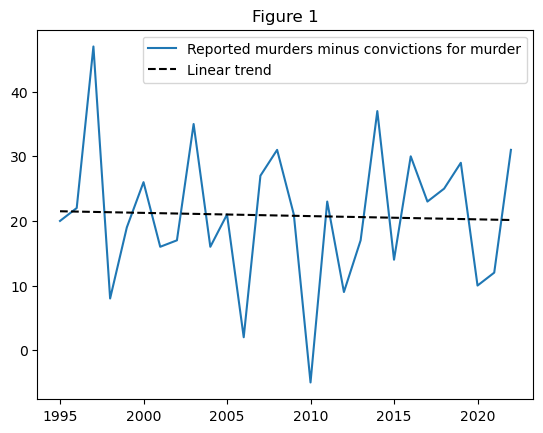

 
-0.05008 x + 121.4


In [6]:
straf_proxy = straf2.loc['Alder i alt'] #Extracting the total conviction rate for each year
straf_proxy = straf_proxy.loc['INDHOLD', 1995:2022] #Limiting the data selection to the years 1995-2022 due to data limitations in the incidence data
anmeldte_proxy = anmeldte.loc['Antal']

 
stationaritet = (anmeldte_proxy-straf_proxy).astype(int) #the difference between number convicted and incidence, forcing object type to integer 
display(stationaritet)
tid_proxy = range(1995,2023) # creating the x-axis
z = np.polyfit(tid_proxy, stationaritet, 1) # fitting trend line
p = np.poly1d(z)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(tid_proxy, stationaritet, label='Reported murders minus convictions for murder')
ax.plot(tid_proxy, p(tid_proxy), color='black', linestyle='--', label='Linear trend')
plt.title('Figure 1')
plt.legend()
plt.show()
print(p)

The relationship appears stationary, perhaps with a very slight downwards trend. Convictions seem to be a good proxy for incidence for our purpose. 

### 3 Age-corrected murder rates

#### 3.1 Importing, exploring, and cleaning data on population structure

In [8]:
#Selektion af værdier for variable 
variables_folk = {'KØN':['1','2'],'ALDER':['>=15'], 'Tid':['1980','1981','1982','1983','1984','1985','1986','1987','1988','1989','1990','1991', 
                                                           '1992','1993','1994','1995','1996','1997','1998','1999','2000','2001','2002','2003',
                                                           '2004','2005', '2006','2007','2008','2009','2010','2011','2012','2013','2014','2015',
                                                           '2016','2017','2018','2019','2020','2021','2022']}
befolkning = Dst.get_data(table_id = 'BEFOLK1', variables=variables_folk)
befolkning.sort_values(by=['KØN', 'ALDER', 'TID'], inplace=True)
del befolkning['CIVILSTAND']

#Sletter karakterer efter et mellemrum og gør variablen numerisk (15 år bliver til 15)
befolkning['ALDER'] = befolkning['ALDER'].apply(lambda x: int(x.split(' ')[0]))

#Laver aldersintervaller, der matcher datasættet straf2
def age_buckets(x):
    if x == 15: 
        return '15 år'
    elif x == 16:
        return '16 år'
    elif x == 17:
        return '17 år'
    elif x == 18:
        return '18 år'
    elif x == 19:
        return '19 år'
    elif x == 20:
        return '20 år'
    elif x == 21:
        return '21 år'
    elif x == 22:
        return '22 år'
    elif x == 23:
        return '23 år'
    elif x == 24:
        return '24 år'
    elif x > 24 and x < 30:
        return '25-29 år'
    elif x < 40: 
        return '30-39 år' 
    elif x < 50: 
        return '40-49 år' 
    elif x < 60: 
        return '50-59 år' 
    elif x < 70: 
        return '60-69 år' 
    elif x < 80: 
        return '70-79 år' 
    elif x >=80: 
        return '80 år og derover' 
    else: return 'other'
befolkning['aldersinterval'] = befolkning.ALDER.apply(lambda x: age_buckets(x))
del befolkning['ALDER']

bef_sum = befolkning.groupby(['aldersinterval', 'TID']).sum(numeric_only=1) #aggregating over the variables we need

bef = pd.pivot_table(bef_sum, index = ['aldersinterval'], columns = ['TID']) #Pivoting into a more useful format

bef.columns = bef.columns.droplevel() #Dropping unneeded level header

samletalder = bef_sum.groupby(['TID']).sum(numeric_only=1) #Calculating aggregate population for each year
samletalder = pd.pivot_table(samletalder, columns = ['TID'])

newv = pd.concat([bef, samletalder], axis=0, join='inner') #Concatenating aggregate population to table
newv = newv.rename(index={'INDHOLD':'Alder i alt'})

newv.style.set_caption('Table 3 - Population distribution 1980-2022')


TID,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
15 år,82114,84428,87253,80577,73967,71115,71062,75109,75463,71950,71760,72774,66316,63158,63449,60842,59381,55422,55325,53693,54857,57039,58695,59400,62290,64810,66934,67397,70522,70083,72546,72310,69887,69593,68174,68119,69127,67555,66614,67512,67768,67877,69009
16 år,81265,82317,84493,87333,80743,74189,71410,71374,75402,75693,72139,71982,72992,66604,63371,63674,61332,59661,55628,55612,53909,55092,57368,58961,59663,62451,64930,67088,67595,70993,70482,73020,72740,70278,70073,68822,68772,69839,68201,67142,67948,68246,68420
17 år,76616,81289,82329,84496,87411,80859,74424,71753,71565,75430,75748,72311,72171,73199,66806,63598,64133,61763,60017,56028,56001,54377,55660,57896,59431,60082,62823,65272,67450,68043,71164,70615,73204,72834,70507,70306,69287,69260,70115,68260,67304,68088,68469
18 år,75478,76817,81383,82488,84612,87606,81104,74925,72072,71691,75610,76025,72670,72701,73604,67087,64140,64551,62015,60266,56258,56166,54550,55763,57917,59419,60082,62838,65339,67633,68151,71376,70840,73491,73255,70973,71131,70008,69781,70566,68639,67674,68674
19 år,75330,75424,76532,81138,82224,84440,87401,81301,74846,71571,71373,75228,75683,72239,72247,73216,67118,64110,64472,61971,60308,56297,56279,54746,55793,57820,59444,60226,63357,66175,68585,69145,72454,72028,74737,74684,72647,72688,71269,70935,71623,69581,69151
20 år,73218,75333,75364,76568,81303,82523,84940,88033,81564,74744,71870,71740,75683,76205,72760,72756,73907,67713,64599,64867,62490,60651,56751,56808,55153,56229,58521,60343,61689,64794,67428,69776,70821,73946,73470,76210,76989,74572,74585,72820,72131,72666,71267
21 år,74043,73194,75281,75388,76709,81497,82968,85488,88291,81491,75061,72338,72327,76317,76924,73418,73744,74718,68402,65362,65704,63238,61593,57659,57655,56176,57324,59774,62081,63414,66525,68877,71793,72131,75528,74883,78470,78567,76294,75806,73901,72840,74538
22 år,74277,73846,73065,75254,75565,76871,81942,83526,85630,88133,81560,75440,72587,72811,76699,77293,74122,74244,75239,69094,66072,66342,63981,62319,58340,58419,57175,58392,61318,63704,64575,67544,70043,72597,73075,76460,76602,79900,79720,77306,76462,74517,74686
23 år,75190,74111,73732,73005,75258,75610,77430,82438,83640,85461,88189,81801,75791,72863,73188,76982,77911,74641,74748,75689,69520,66431,66898,64408,62695,58756,59098,58024,59737,62761,64683,65672,68614,71337,73849,74419,78420,78399,81298,80841,78029,77321,76345
24 år,75020,75084,74006,73661,72993,75366,76119,77932,82518,83640,85432,88366,82115,76128,73294,73442,77489,78451,74932,75063,76001,69752,66743,67195,64618,62961,59249,59722,58972,61022,63324,65590,66204,69614,72352,75068,76268,79884,79675,82217,81368,78560,78611


#### 3.2 Calculating murder rate

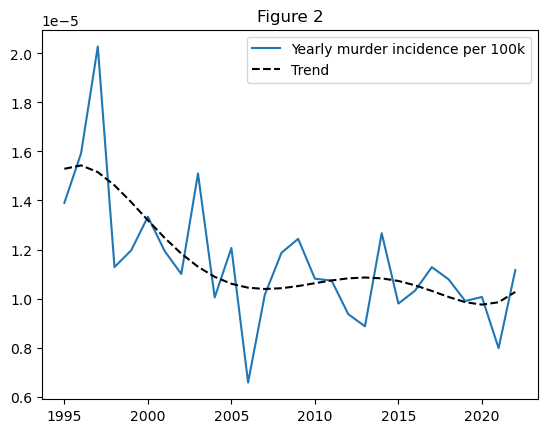

In [9]:
#3.2.1 Illustrating the murder rate 1995-2022
z3 = np.polyfit(tid_proxy, anmeldte.loc['Antal',:].div(newv.loc['Alder i alt',1995:2023]), 5) # fitting trend line
p3 = np.poly1d(z3)
fig3 = plt.figure()
ax3 = fig3.add_subplot(1,1,1)
ax3.plot(tid_proxy, anmeldte.loc['Antal',:].div(newv.loc['Alder i alt',1995:2023]), label='Yearly murder incidence per 100k')
ax3.plot(tid_proxy, p3(tid_proxy), color='black', linestyle='--', label='Trend')
plt.title('Figure 2')
plt.legend()
plt.show()

The murder rate appears to have dropped since the mid 90's. 

         TID 
INDHOLD  1980    0.668212
         1981    0.786411
         1982    0.805106
         1983    0.969894
         1984    0.820710
         1985    0.721086
         1986    1.004510
         1987    0.808208
         1988    0.709560
         1989    0.754633
         1990    0.775585
         1991    0.608495
         1992    0.933014
         1993    0.907388
         1994    0.719693
         1995    0.927041
         1996    1.085113
         1997    0.945098
         1998    0.944119
         1999    0.759330
         2000    0.735823
         2001    0.826693
         2002    0.710496
         2003    0.709307
         2004    0.639260
         2005    0.728389
         2006    0.612026
         2007    0.406052
         2008    0.492625
         2009    0.777197
         2010    1.191154
         2011    0.569483
         2012    0.740086
         2013    0.518915
         2014    0.472248
         2015    0.681276
         2016    0.400255
         2017    0.64756

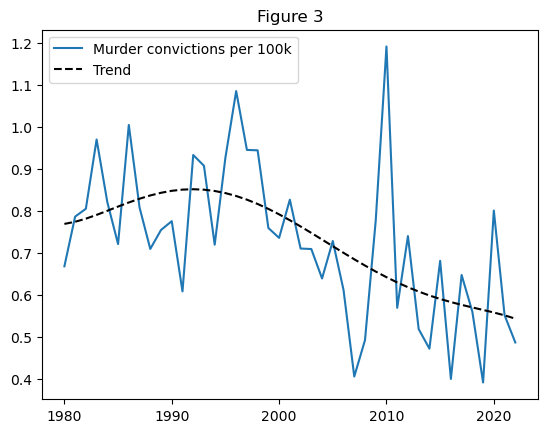

In [10]:
#3.2.2 Illustrating the murder conviction rate 1980-2022
mordrate = straf2.div(newv)*100000 #Mord pr 100.000 indbyggere
mordrate.style.set_caption('Table 4 - Murder convictions per capita 1980-2022')


mordrateialt = mordrate.loc['Alder i alt',:].astype(float)
display(mordrateialt)

tid1 = range(1980, 2023, 1)
z1 = np.polyfit(tid1, mordrateialt, 5) # fitting trend line
p1 = np.poly1d(z1)
fig1 = plt.figure()
ax1 = fig1.add_subplot(1,1,1)
ax1.plot(tid1, mordrateialt, label='Murder convictions per 100k')
ax1.plot(tid1, p1(tid1), color='black', linestyle='--', label='Trend')
plt.title('Figure 3')
plt.legend()
plt.show()


#### 3.3 Computing the age-corrected murder conviction rate

         TID 
INDHOLD  1980    0.668212
         1981    0.788372
         1982    0.808239
         1983    0.975865
         1984    0.818347
         1985    0.732239
         1986    0.980693
         1987    0.830444
         1988    0.709353
         1989    0.757042
         1990    0.773619
         1991    0.626111
         1992    0.928634
         1993    0.924243
         1994    0.714681
         1995    0.914767
         1996    1.096758
         1997    0.938900
         1998    0.941513
         1999    0.759783
         2000    0.738219
         2001    0.799552
         2002    0.707382
         2003    0.720003
         2004    0.730223
         2005    0.768208
         2006    0.651305
         2007    0.477079
         2008    0.568841
         2009    0.804710
         2010    1.246150
         2011    0.634187
         2012    0.815292
         2013    0.549018
         2014    0.519244
         2015    0.803603
         2016    0.440023
         2017    0.70755

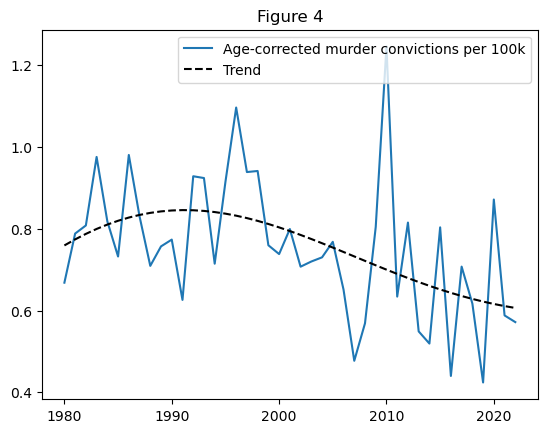

In [15]:
alford = newv.loc[:,1980].div(newv.loc['Alder i alt', 1980]) #age distribution in the year of our lord 1980

mordrate2 = mordrate.mul(alford, axis=0) #Weighted age-specific murder conviction rates
mordrate2.drop(labels=['Alder i alt'], axis=0, inplace=True)

mordrate3 = mordrate2.sum().astype(float) #yearly age-corrected murder conviction rate

display(mordrate3)


z2 = np.polyfit(tid1, mordrate3, 5) # fitting trend line
p2 = np.poly1d(z2)
fig2 = plt.figure()
ax2 = fig2.add_subplot(1,1,1)
ax2.plot(tid1, mordrate3, label='Age-corrected murder convictions per 100k')
ax2.plot(tid1, p2(tid1), color='black', linestyle='--', label='Trend')
plt.title('Figure 4')
plt.legend()
plt.show()



The result is similar to the non-corrected rates, but more muted. Importantly, the trend is not reversed by the correction. 
We remain convinced that the olden times were superior, so we run a simple regression to see if probability can explain the variation. 

In [9]:
tidreg = sm.add_constant(tid1)
model = sm.OLS(mordrate3, tidreg)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.170
Model:                            OLS   Adj. R-squared:                  0.150
Method:                 Least Squares   F-statistic:                     8.399
Date:                Sat, 15 Apr 2023   Prob (F-statistic):            0.00600
Time:                        22:37:44   Log-Likelihood:                 19.789
No. Observations:                  43   AIC:                            -35.58
Df Residuals:                      41   BIC:                            -32.06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.9003      3.846      3.094      0.0

Looks like it aint random

Overvej at tage <15 år med i samlet population for sammenlignelighed med anden stat

-1,35/55 = 2,5 pct. 

0,233/0,668 = 35 pct. 

variationen kan nok ikke forklares af proxyudviklingen, men måske alligevel med i regressionen, men nok multikollineær..?